In [5]:
from __future__ import annotations

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

SAM_CHECKPOINT = "./model/sam_vit_h_4b8939.pth"
MODEL_TYPE = "default"


class AutoSegmentImage:
    def __init__(self, img_path: str | Path, device="cuda"):
        self.image = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        self.device = device
        self.masks = None

    def plot_image(self):
        plt.imshow(self.image)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def get_masks(self, sam_checkpoint=SAM_CHECKPOINT, model_type=MODEL_TYPE, **kwargs):
        from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

        sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        sam.to(device=self.device)

        mask_generator = SamAutomaticMaskGenerator(model=sam, **kwargs)
        self.masks = mask_generator.generate(self.image)
        return mask_generator.generate(self.image)

    def plot_masks(self, **kwargs):
        def show_segments(segments):
            if len(segments) == 0:
                return
            sorted_anns = sorted(segments, key=(lambda x: x['area']), reverse=True)
            ax = plt.gca()
            ax.set_autoscale_on(False)
            for ann in tqdm(sorted_anns):
                m = ann['segmentation']
                img = np.ones((m.shape[0], m.shape[1], 3))
                color_mask = np.random.random((1, 3)).tolist()[0]
                for i in range(3):
                    img[:, :, i] = color_mask[i]
                ax.imshow(np.dstack((img, m * 0.35)))

        masks = self.get_masks(**kwargs)
        plt.imshow(self.image)
        show_segments(masks)
        plt.axis('off')

        plt.tight_layout()
        plt.show()


Demo picture: https://unsplash.com/photos/6KLyD-cUFhc

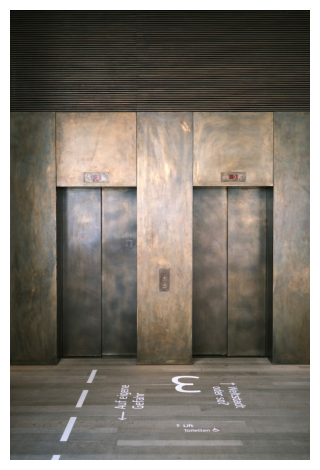

In [6]:
img = AutoSegmentImage(Path("./data/demo.jpg"))
img.plot_image()

下一段中的 `options` 参数配置可参考：[mask_generator_example](https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb)

100%|██████████| 32/32 [00:00<00:00, 43.63it/s]


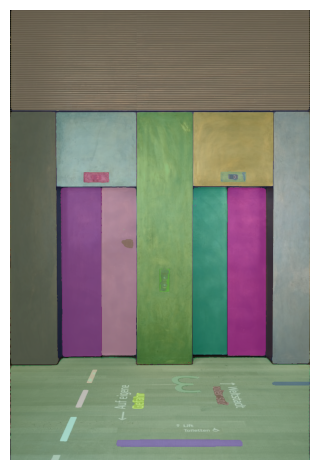

In [7]:
options = {}
img.plot_masks(**options)

`masks['segmentation']` 是一个元素值为Bool值的 `np.ndarray`，矩阵大小与图片像素宽高相等。值为 `True` 对应 mask 的所在区域，可通过 `np.where` 获取：

In [8]:
mask = img.masks[1]
mask_index = np.where(mask['segmentation'])